In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [2]:
df=pd.read_csv("diabetes.csv")

In [3]:
def check_df(dataframe):
    print(f"""
        ##################### Shape #####################\n\n\t{dataframe.shape}\n\n
        ##################### Types #####################\n\n{dataframe.dtypes}\n\n
        ##################### Head #####################\n\n{dataframe.head(5)}\n\n
        ##################### Tail #####################\n\n{dataframe.tail(5)}\n\n
        ##################### NA #####################\n\n{dataframe.isnull().sum()}\n\n
        ##################### Describe #####################\n\n{dataframe.describe()}\n\n

        """)

In [4]:
check_df(df)


        ##################### Shape #####################

	(768, 9)


        ##################### Types #####################

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


        ##################### Head #####################

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outc

In [5]:
num_cols=df.select_dtypes(["int64","Float64"]).columns

### 🔍 Column-wise Risk Thresholds & Medical Interpretation

| **Column**                  | **Normal Range**                                                                 | **Risky / Interpretation**                                               |
|----------------------------|-----------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| **Pregnancies**            | 0–6 (typical)                                                                     | More pregnancies can increase risk, especially ≥ 6 (gestational diabetes history). |
| **Glucose (mg/dL)**        | - Normal: 70–99  <br> - Prediabetes: 100–125  <br> - Diabetes: ≥ 126              | ✅ ≥ 126 is a strong indicator of diabetes.                               |
| **BloodPressure (mm Hg)**  | - Normal: 80 or less  <br> - Elevated: 81–89  <br> - High: ≥ 90                   | ✅ Diastolic ≥ 90 is considered high and may be linked with diabetes risk. |
| **SkinThickness (mm)**     | - Typical: 10–30  <br> - > 32: Obesity indicator                                 | ✅ ≥ 32 suggests higher fat levels → diabetes risk.                       |
| **Insulin (μU/ml)**        | - Normal: 16–166 (2-hour post meal)                                              | ✅ Too low (e.g., < 15) or too high (e.g., > 200) can be a concern.       |
| **BMI**                    | - Normal: 18.5–24.9  <br> - Overweight: 25–29.9  <br> - Obese: ≥ 30               | ✅ ≥ 30 is obesity → strong diabetes risk.                                |
| **DiabetesPedigreeFunction**| - Normal: ≤ 0.4  <br> - Moderate: 0.4–0.6  <br> - High: > 0.6                    | ✅ > 0.6 = strong family history risk.                                    |
| **Age**                    | - Low Risk: < 35  <br> - Medium Risk: 35–50  <br> - High Risk: > 50               | ✅ Risk increases significantly after 45–50 years.                        |


In [6]:
for col in df.columns:
    print(df[col].describe())
    print()

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: Pregnancies, dtype: float64

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
max       99.000000
Name: SkinThickness, dtype: float64

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64

count    768.000000
mean     

- The dataset contains significant **missing values** in `Insulin`, `SkinThickness`, and `BloodPressure` (many zeroes).
- On average, individuals are **overweight or obese** (BMI ≈ 32).
- Most participants are **under 45**, but some are elderly (up to age 81), where risk increases.
- **35% of participants are diabetic**, giving the dataset some class imbalance.
- `Glucose` and `BMI` are two of the strongest indicators in the dataset.


In [7]:
zero_as_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [8]:
df_non_zero=df[~(df[zero_as_missing]==0).any(axis=1)].copy()

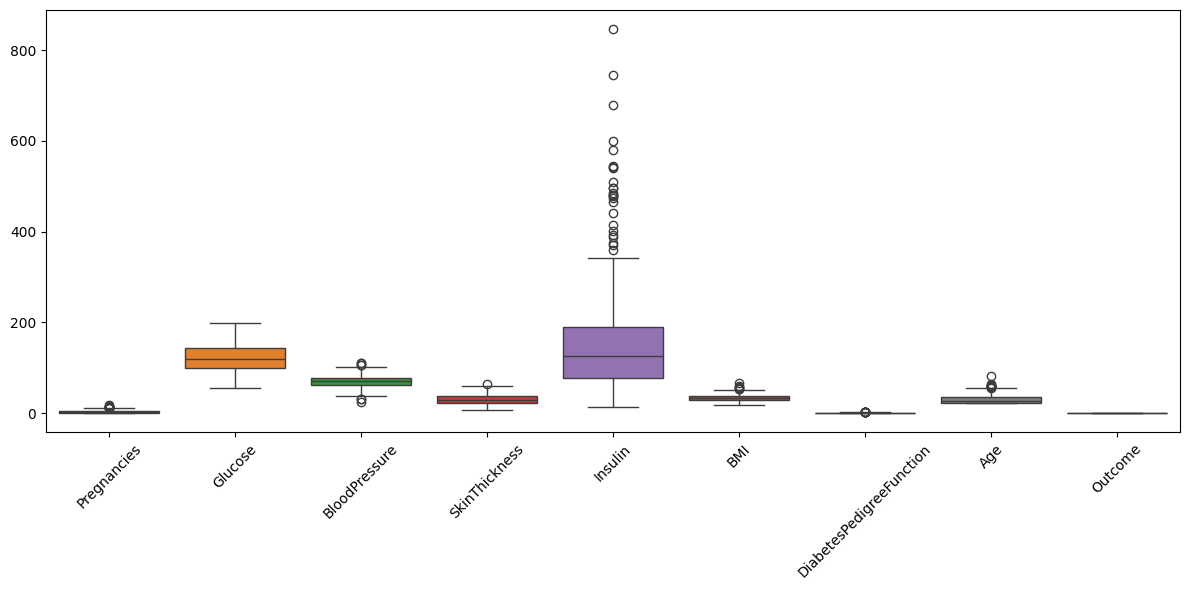

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_non_zero)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
df_clean = df_non_zero.copy()
for col in df_non_zero.columns:
    Q1 = df_non_zero[col].quantile(0.25)
    Q3 = df_non_zero[col].quantile(0.75)
    IQR = Q3 - Q1
    low_bound = Q1 - 1.5 * IQR
    up_bound = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] > low_bound) & (df_clean[col] < up_bound)]

In [13]:
df_non_zero.shape

(392, 9)

In [14]:
df_clean.shape

(323, 9)

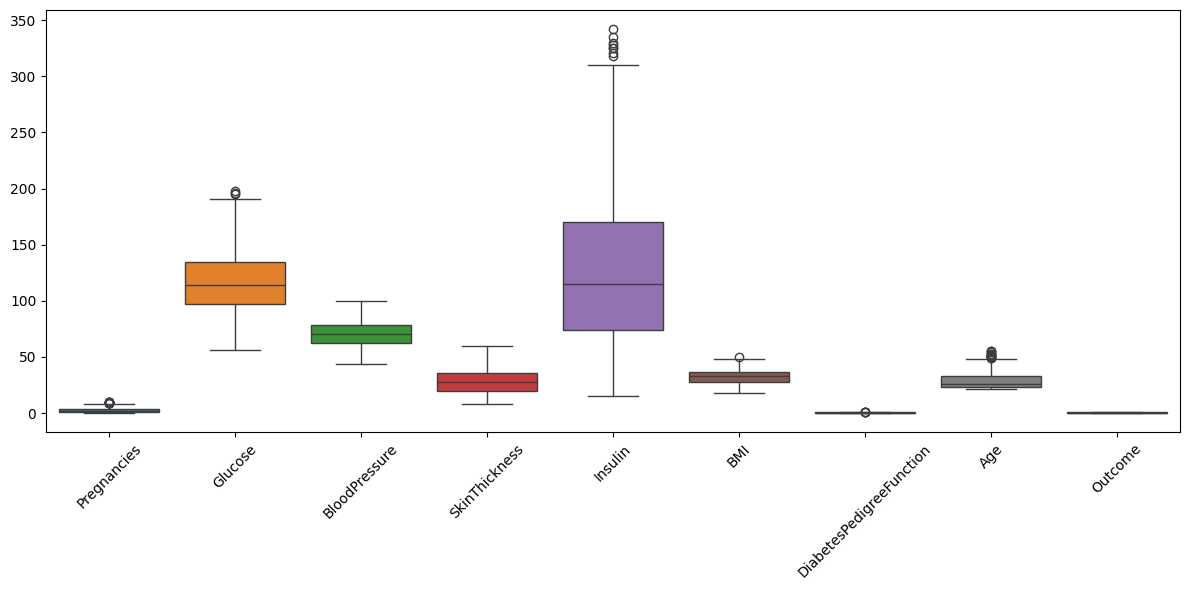

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
x=df_non_zero.values
clf=LocalOutlierFactor(n_neighbors=20,contamination=0.3)
y_pred=clf.fit_predict(x)
df_non_zero['LOF_outlier'] = y_pred
df_no_outliers = df_non_zero[df_non_zero['LOF_outlier'] == 1].drop(columns='LOF_outlier')

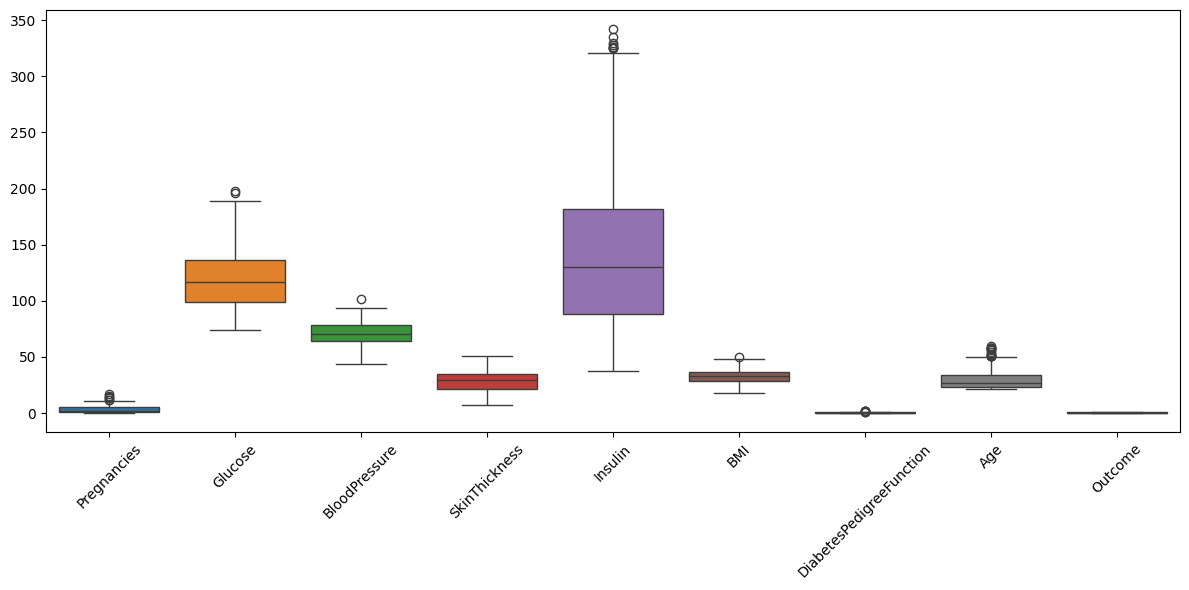

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_no_outliers)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()